# <span style="font-weight: bolder;">Spatial Clustering Demonstration of Breast cancer (10xVisium)</span>
In this Tutorial, we demonstrate how to use 3d-OT to obtain the clustering results of Breast cancer

## <span style="font-weight: bolder;">Loading package</span>

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.single_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## <span style="font-weight: bolder;">Loading data</span>
<p>We use SCANPY package to select Top3000 HVGs and perform standard data processing,The standard processed expression matrix <span class="pre" style="color: red; font-family: monospace; background-color:#f6f8fa; padding: 2px 4px; border-radius: 4px;">adata.X</span>is used as input</p>



In [3]:
adata=sc.read_visium('/home/dbj/mouse/vision3/')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
cluster=pd.read_csv('/home/dbj/mouse/metadata.tsv',sep='\t',index_col=0)
adata.obs['truth']=cluster['ground_truth']
adata.obs['truth'] = adata.obs['truth'].astype('category')
adata.obsm['feat']=adata.X

## <span style="font-weight: bolder;">The ground truth of breast cancer</span>

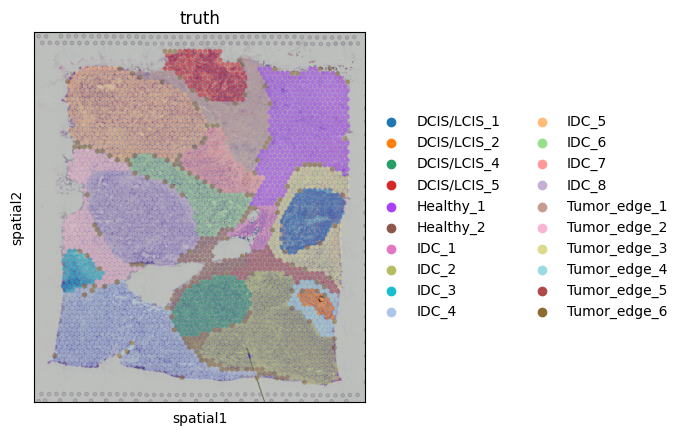

In [4]:
sc.pl.spatial(adata, img_key="hires", color="truth", alpha=0.5, size=1.5)

## <span style="font-weight: bolder;">Construct a neighbor graph and train PointNet++Encoder</span>

In [5]:
set_seed(8)
graph = prepare_data(adata, location="spatial", nb_neighbors=16).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.678885, Min Loss: 0.679147

<!-- ### <span style="font-weight: bolder;">Obtain the reconstruction matrix</span>  <span class="pre" style="color: red; font-family: monospace; background-color:#f6f8fa; padding: 2px 4px; border-radius: 4px;">decoded_features</span> -->
### Obtain the reconstruction matrix `decoded_features`

In [6]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

## <span style="font-weight: bolder;">We use mcluster for clustering</span>

In [7]:
clustering(adata, n_clusters=20, radius=50, key='3d-OT', method='mclust', refinement=True,random=38,n_comp=10)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


## <span style="font-weight: bolder;">The clustering result of breast cancer</span>

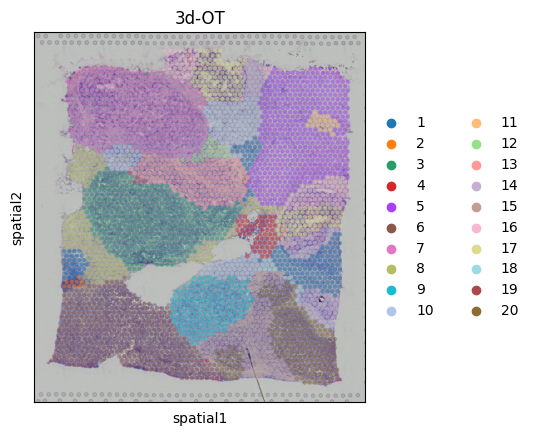

In [8]:
sc.pl.spatial(adata, color='3d-OT', img_key='hires', alpha=0.5, size=1.3)

## <span style="font-weight: bolder;">Calculate supervision metrics ARI and NMI</span>

In [ ]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI